In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Week 12 - Difference-In-Difference With Violated Parallel Trends

## Constructing the dataset

In [3]:
def generate_violated_trends_data(n_periods=100, treatment_time=60):
    # Generate data where parallel trends assumption is violated
    
    # Scenario: Effect of new technology adoption on firm productivity
    # - Treatment group: Tech-savvy firms (early adopters)
    # - Control group: Traditional firms (late adopters)
    # - Violation: Treatment group has accelerating growth pre-treatment
    # - True treatment effect: 5 units
    
    data = []
    
    for group_type in ['treatment', 'control']:
        for t in range(1, n_periods + 1):
            
            if group_type == 'treatment':
                # Treatment group: accelerating growth before treatment
                if t <= treatment_time:
                    # Pre-treatment: y = 20 + 0.4*t + 0.008*t² (accelerating)
                    y_base = 20 + 0.4 * t + 0.008 * t**2
                    treated = 0
                else:
                    # Post-treatment: same trend + treatment effect of 5
                    y_base = 20 + 0.4 * t + 0.008 * t**2 + 5
                    treated = 1
                    
            else:  # control group
                # Control group: steady linear growth (no acceleration)
                # y = 15 + 0.5*t (constant slope)
                y_base = 15 + 0.5 * t
                treated = 0
            
            # Add noise
            y_observed = y_base + np.random.normal(0, 1.5)
            
            # Calculate what SHOULD happen in counterfactual world
            if group_type == 'treatment' and t > treatment_time:
                y_counterfactual = 20 + 0.4 * t + 0.008 * t**2  # No treatment effect
                true_treatment_effect = 5  # True effect
            else:
                y_counterfactual = y_base
                true_treatment_effect = 0
            
            data.append({
                'time': t,
                'group': group_type,
                'treated': treated,
                'post_treatment': 1 if t > treatment_time else 0,
                'y_observed': y_observed,
                'y_true': y_base,
                'y_counterfactual': y_counterfactual,
                'true_effect': true_treatment_effect
            })
    
    return pd.DataFrame(data)

# Generate the dataset
df = generate_violated_trends_data()
treatment_time = 60

print(f"Dataset created with {len(df)} observations")
print(f"Treatment starts at time {treatment_time}")
print(f"Groups: {df['group'].unique()}")
print(f"True treatment effect: 5 units")

# Show the trends by group
pre_treatment = df[df['post_treatment'] == 0]
print(f"\nPRE-TREATMENT TRENDS:")
for group in df['group'].unique():
    group_data = pre_treatment[pre_treatment['group'] == group]
    
    # Fit linear trend to pre-treatment period
    X = sm.add_constant(group_data['time'])
    model = sm.OLS(group_data['y_observed'], X).fit()
    slope = model.params['time']
    
    print(f"{group.capitalize()} group slope: {slope:.4f}")

Dataset created with 200 observations
Treatment starts at time 60
Groups: ['treatment' 'control']
True treatment effect: 5 units

PRE-TREATMENT TRENDS:
Treatment group slope: 0.8786
Control group slope: 0.4842


## Standard Difference-In-Difference Estimation

In [6]:
def estimate_did_standard(df):
    # Standard DiD: y = α + β₁*treatment_group + β₂*post + β₃*(treatment_group*post) + ε
    # Where β₃ is the DiD estimate
    
    # Create treatment group dummy
    df['treatment_group'] = (df['group'] == 'treatment').astype(int)
    
    X = pd.DataFrame({
        'const': np.ones(len(df)),
        'treatment_group': df['treatment_group'].astype(float),
        'post_treatment': df['post_treatment'].astype(float),
        'did_interaction': (df['treatment_group'] * df['post_treatment']).astype(float)
    })
    
    model = sm.OLS(df['y_observed'], X).fit()
    return model

# Estimate standard DiD
did_model = estimate_did_standard(df)

print("STANDARD DIFFERENCE-IN-DIFFERENCES RESULTS:")
print(f"DiD Estimate: {did_model.params['did_interaction']:.3f}")
print(f"Standard Error: {did_model.bse['did_interaction']:.3f}")
print(f"P-value: {did_model.pvalues['did_interaction']:.4f}")
print(f"95% CI: [{did_model.conf_int().loc['did_interaction', 0]:.3f}, {did_model.conf_int().loc['did_interaction', 1]:.3f}]")


STANDARD DIFFERENCE-IN-DIFFERENCES RESULTS:
DiD Estimate: 42.892
Standard Error: 3.863
P-value: 0.0000
95% CI: [35.273, 50.510]


## DID Calculation

In [8]:
# Calculate group means by period
group_means = df.groupby(['group', 'post_treatment'])['y_observed'].mean().reset_index()
print("Group Means by Period:")
print(group_means.pivot(index='group', columns='post_treatment', values='y_observed'))

# Manual DiD calculation
treatment_pre = group_means[(group_means['group'] == 'treatment') & (group_means['post_treatment'] == 0)]['y_observed'].iloc[0]
treatment_post = group_means[(group_means['group'] == 'treatment') & (group_means['post_treatment'] == 1)]['y_observed'].iloc[0]
control_pre = group_means[(group_means['group'] == 'control') & (group_means['post_treatment'] == 0)]['y_observed'].iloc[0]
control_post = group_means[(group_means['group'] == 'control') & (group_means['post_treatment'] == 1)]['y_observed'].iloc[0]

treatment_change = treatment_post - treatment_pre
control_change = control_post - control_pre
did_estimate = treatment_change - control_change

print(f"\nMANUAL DID CALCULATION:")
print(f"Treatment group change: {treatment_post:.2f} - {treatment_pre:.2f} = {treatment_change:.2f}")
print(f"Control group change: {control_post:.2f} - {control_pre:.2f} = {control_change:.2f}")
print(f"DiD estimate: {treatment_change:.2f} - {control_change:.2f} = {did_estimate:.2f}")


# DECOMPOSITION
print("\nBIAS DECOMPOSITION: WHY DID GOES WRONG")
print("-" * 45)

print("UNDERSTANDING THE BIAS:")

# Calculate what the treatment group WOULD have been without treatment
treatment_post_data = df[(df['group'] == 'treatment') & (df['post_treatment'] == 1)]
treatment_counterfactual = treatment_post_data['y_counterfactual'].mean()
treatment_observed_post = treatment_post_data['y_observed'].mean()

true_treatment_effect = treatment_observed_post - treatment_counterfactual

print(f"True treatment effect: {true_treatment_effect:.2f}")
print(f"DiD estimate: {did_estimate:.2f}")
print(f"Bias: {did_estimate - true_treatment_effect:.2f}")

print(f"\nSOURCE OF BIAS:")
print(f"DiD assumes control group shows what treatment group would have done")
print(f"But treatment group has ACCELERATING growth, control group has LINEAR growth")

# Show the differential trends
pre_period_length = len(df[df['post_treatment'] == 0]) // 2  # per group
treatment_pre_early = df[(df['group'] == 'treatment') & (df['time'] <= 30)]['y_observed'].mean()
treatment_pre_late = df[(df['group'] == 'treatment') & (df['time'] > 30) & (df['time'] <= treatment_time)]['y_observed'].mean()
control_pre_early = df[(df['group'] == 'control') & (df['time'] <= 30)]['y_observed'].mean()
control_pre_late = df[(df['group'] == 'control') & (df['time'] > 30) & (df['time'] <= treatment_time)]['y_observed'].mean()

treatment_pre_acceleration = (treatment_pre_late - treatment_pre_early) / 30
control_pre_acceleration = (control_pre_late - control_pre_early) / 30

print(f"\nPRE-TREATMENT ACCELERATION COMPARISON:")
print(f"Treatment group acceleration: {treatment_pre_acceleration:.4f} per period")
print(f"Control group acceleration: {control_pre_acceleration:.4f} per period")
print(f"Difference in acceleration: {treatment_pre_acceleration - control_pre_acceleration:.4f}")


Group Means by Period:
post_treatment          0           1
group                                
control         29.935042   55.290041
treatment       41.885249  110.132109

MANUAL DID CALCULATION:
Treatment group change: 110.13 - 41.89 = 68.25
Control group change: 55.29 - 29.94 = 25.35
DiD estimate: 68.25 - 25.35 = 42.89

BIAS DECOMPOSITION: WHY DID GOES WRONG
---------------------------------------------
UNDERSTANDING THE BIAS:
True treatment effect: 5.02
DiD estimate: 42.89
Bias: 37.87

SOURCE OF BIAS:
DiD assumes control group shows what treatment group would have done
But treatment group has ACCELERATING growth, control group has LINEAR growth

PRE-TREATMENT ACCELERATION COMPARISON:
Treatment group acceleration: 0.8614 per period
Control group acceleration: 0.5049 per period
Difference in acceleration: 0.3565


## Visualization

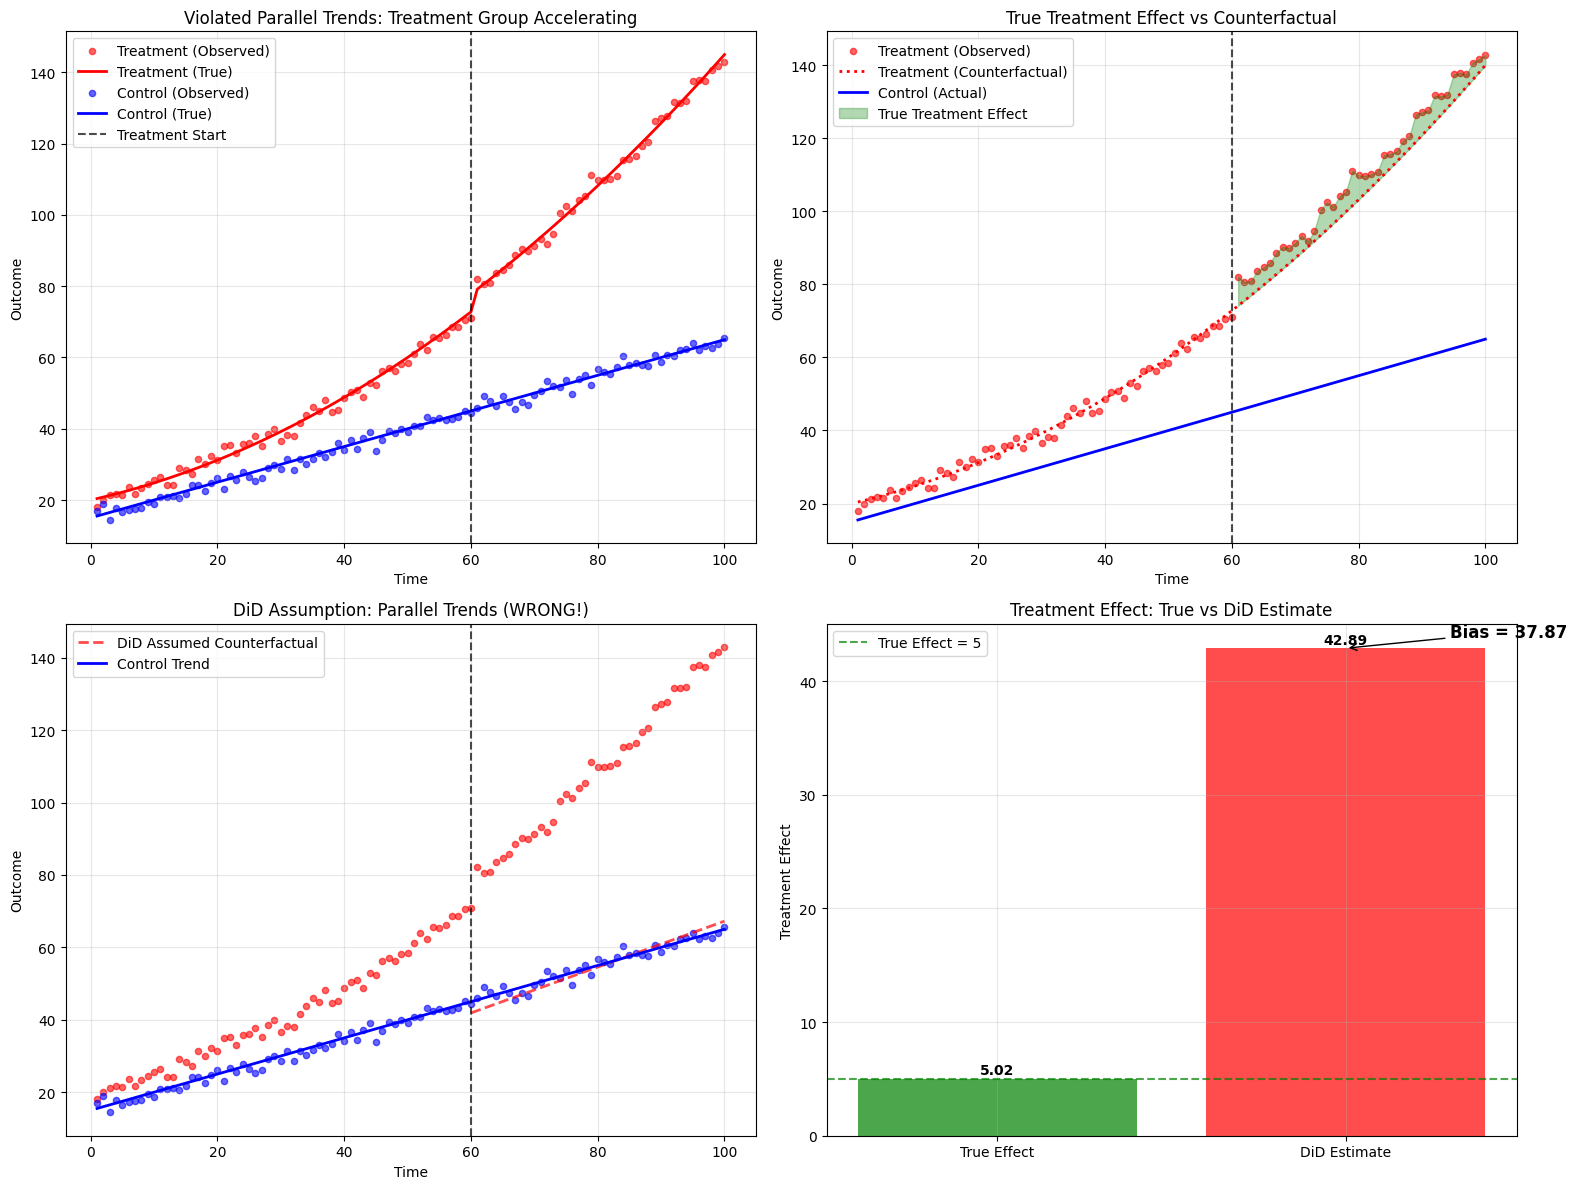

In [9]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Raw data showing violated parallel trends
treatment_data = df[df['group'] == 'treatment']
control_data = df[df['group'] == 'control']

ax1.scatter(treatment_data['time'], treatment_data['y_observed'], alpha=0.6, color='red', s=20, label='Treatment (Observed)')
ax1.plot(treatment_data['time'], treatment_data['y_true'], color='red', linewidth=2, label='Treatment (True)')
ax1.scatter(control_data['time'], control_data['y_observed'], alpha=0.6, color='blue', s=20, label='Control (Observed)')
ax1.plot(control_data['time'], control_data['y_true'], color='blue', linewidth=2, label='Control (True)')
ax1.axvline(x=treatment_time, color='black', linestyle='--', alpha=0.7, label='Treatment Start')
ax1.set_xlabel('Time')
ax1.set_ylabel('Outcome')
ax1.set_title('Violated Parallel Trends: Treatment Group Accelerating')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Counterfactual analysis
treatment_post = treatment_data[treatment_data['post_treatment'] == 1]
ax2.scatter(treatment_data['time'], treatment_data['y_observed'], alpha=0.6, color='red', s=20, label='Treatment (Observed)')
ax2.plot(treatment_data['time'], treatment_data['y_counterfactual'], color='red', linestyle=':', linewidth=2, label='Treatment (Counterfactual)')
ax2.plot(control_data['time'], control_data['y_true'], color='blue', linewidth=2, label='Control (Actual)')
ax2.axvline(x=treatment_time, color='black', linestyle='--', alpha=0.7)
ax2.fill_between(treatment_post['time'], treatment_post['y_observed'], treatment_post['y_counterfactual'], 
                alpha=0.3, color='green', label='True Treatment Effect')
ax2.set_xlabel('Time')
ax2.set_ylabel('Outcome')
ax2.set_title('True Treatment Effect vs Counterfactual')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: DiD visualization - the wrong assumption
ax3.scatter(treatment_data['time'], treatment_data['y_observed'], alpha=0.6, color='red', s=20)
ax3.scatter(control_data['time'], control_data['y_observed'], alpha=0.6, color='blue', s=20)

# Show what DiD assumes (parallel counterfactual)
post_control_trend = control_post - control_pre
did_assumed_counterfactual = treatment_pre + post_control_trend
treatment_post_points = treatment_data[treatment_data['post_treatment'] == 1]['time']
did_counterfactual_line = treatment_pre + (treatment_post_points - treatment_time) * (control_change / (100 - treatment_time))

ax3.plot([treatment_time, 100], [treatment_pre, treatment_pre + post_control_trend], 
         'r--', linewidth=2, alpha=0.7, label='DiD Assumed Counterfactual')
ax3.plot(control_data['time'], control_data['y_true'], 'b-', linewidth=2, label='Control Trend')
ax3.axvline(x=treatment_time, color='black', linestyle='--', alpha=0.7)
ax3.set_xlabel('Time')
ax3.set_ylabel('Outcome')
ax3.set_title('DiD Assumption: Parallel Trends (WRONG!)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Bias visualization
effects_comparison = pd.DataFrame({
    'Method': ['True Effect', 'DiD Estimate'],
    'Effect_Size': [true_treatment_effect, did_estimate],
    'Color': ['green', 'red']
})

bars = ax4.bar(effects_comparison['Method'], effects_comparison['Effect_Size'], 
               color=['green', 'red'], alpha=0.7)
ax4.axhline(y=5, color='green', linestyle='--', alpha=0.7, label='True Effect = 5')
ax4.set_ylabel('Treatment Effect')
ax4.set_title('Treatment Effect: True vs DiD Estimate')

# Add value labels on bars
for bar, value in zip(bars, effects_comparison['Effect_Size']):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{value:.2f}', ha='center', va='bottom', fontweight='bold')

# Add bias annotation
bias = did_estimate - true_treatment_effect
ax4.annotate(f'Bias = {bias:.2f}', xy=(1, did_estimate), xytext=(1.3, did_estimate + 1),
            arrowprops=dict(arrowstyle='->', color='black'), fontsize=12, fontweight='bold')

ax4.grid(True, alpha=0.3)
ax4.legend()

plt.tight_layout()
plt.show()

## Trend-Adjusted DID

In [10]:
def estimate_trend_adjusted_did(df):
    # Trend-adjusted DiD that allows for group-specific time trends
    # y = α + β₁*treatment + β₂*post + β₃*time + β₄*(treatment*time) + β₅*(treatment*post) + ε

    
    df['treatment_group'] = (df['group'] == 'treatment').astype(int)
    
    X = pd.DataFrame({
        'const': np.ones(len(df)),
        'treatment_group': df['treatment_group'].astype(float),
        'post_treatment': df['post_treatment'].astype(float),
        'time': df['time'].astype(float),
        'treatment_time': (df['treatment_group'] * df['time']).astype(float),
        'did_interaction': (df['treatment_group'] * df['post_treatment']).astype(float)
    })
    
    model = sm.OLS(df['y_observed'], X).fit()
    return model

trend_adjusted_model = estimate_trend_adjusted_did(df)

print("TREND-ADJUSTED DiD RESULTS:")
print(f"DiD Estimate: {trend_adjusted_model.params['did_interaction']:.3f}")
print(f"Standard Error: {trend_adjusted_model.bse['did_interaction']:.3f}")
print(f"P-value: {trend_adjusted_model.pvalues['did_interaction']:.4f}")

print(f"\nCOMPARISON OF METHODS:")
print(f"True treatment effect: {true_treatment_effect:.3f}")
print(f"Standard DiD: {did_estimate:.3f} (bias: {did_estimate - true_treatment_effect:.3f})")
print(f"Trend-adjusted DiD: {trend_adjusted_model.params['did_interaction']:.3f} (bias: {trend_adjusted_model.params['did_interaction'] - true_treatment_effect:.3f})")


TREND-ADJUSTED DiD RESULTS:
DiD Estimate: 15.110
Standard Error: 2.241
P-value: 0.0000

COMPARISON OF METHODS:
True treatment effect: 5.024
Standard DiD: 42.892 (bias: 37.868)
Trend-adjusted DiD: 15.110 (bias: 10.086)
